# modDR-Framework example: UCI-50 Image Segmentation

In this example, the moddr framework is demonstrated using the ‘UCI-50 Image Segmentation’ dataset from the UCI Machine Learning Repository. The data set has a moderate number of data points, and the UMAP visualisation already accurately depicts the neighbourhoods for the property based on the selected features. However, outliers can be identified based on the colour coding (based on the first PCA principal component). This data set can therefore be used to measure whether and to what extent the framework can detect outliers and move them in a targeted manner.

The example is intended solely to demonstrate the functions of the framework. The selection of the feature chosen to model a similarity measure to be integrated was not based on content-related arguments, but solely on visual criteria.

Details about the dataset can be found at https://archive.ics.uci.edu/dataset/50/image+segmentation.

The moddr package is required for execution (locally from https://github.com/kohaupt/modDR or as a PYPI package). Instructions for execution and installation can be found in the README.

## Imports

In [ ]:
# may require additional installations of the packages pandas, scikit-learn
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import moddr

## Data exploration

The following steps show the initial visualisation of the dataset using the DR method (here, UMAP), with the modelled property represented by the colour of the data points via the first principal component of PCA. The selection of features has no content-related significance; it merely illustrates the difference in neighbourhood structure compared to the DR's positioning.

In [4]:
# in contrast to the other datasets, the UCI-API does not provide a direct way to retrieve all the data points described in the dataset. Therefore, they must be downloaded and loaded manually into a pandas DataFrame.

# define column names
columns = [
    "region-centroid-col",
    "region-centroid-row",
    "region-pixel-count",
    "short-line-density-5",
    "short-line-density-2",
    "vedge-mean",
    "vedge-sd",
    "hedge-mean",
    "hedge-sd",
    "intensity-mean",
    "rawred-mean",
    "rawblue-mean",
    "rawgreen-mean",
    "exred-mean",
    "exblue-mean",
    "exgreen-mean",
    "value-mean",
    "saturation-mean",
    "hue-mean",
]

# load training data
train_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/image/segmentation.data"
)
train = pd.read_csv(train_url, skiprows=5, header=None)
train.columns = ["class"] + columns

# load test data
test_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/image/segmentation.test"
)
test = pd.read_csv(test_url, skiprows=5, header=None)
test.columns = ["class"] + columns

# combine training and test data
full_data = pd.concat([train, test], ignore_index=True)
X = pd.DataFrame(full_data)
X = X.drop(columns=["class"])
X["region-pixel-count"] = X["region-pixel-count"].astype("float")

X.describe()

,region-centroid-col,region-centroid-row,region-pixel-count,short-line-density-5,short-line-density-2,vedge-mean,vedge-sd,hedge-mean,hedge-sd,intensity-mean,rawred-mean,rawblue-mean,rawgreen-mean,exred-mean,exblue-mean,exgreen-mean,value-mean,saturation-mean,hue-mean
count,2310.000000,2310.000000,2310.0,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2.310000e+03,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000
mean,124.913853,123.417316,9.0,0.014334,0.004714,1.893939,5.709320,2.424723,8.243692e+00,37.051595,32.821308,44.187879,34.145599,-12.690861,21.408850,-8.717989,45.137470,0.426893,-1.362897
std,72.956532,57.483851,0.0,0.040154,0.024234,2.698908,44.846457,3.610084,5.881152e+01,38.176410,35.036774,43.527461,36.364773,11.583562,19.571819,11.551628,42.921764,0.228309,1.545335
min,1.000000,11.000000,9.0,0.000000,0.000000,0.000000,0.000000,0.000000,-1.589457e-08,0.000000,0.000000,0.000000,0.000000,-49.666668,-12.444445,-33.888890,0.000000,0.000000,-3.044175
25%,62.000000,81.000000,9.0,0.000000,0.000000,0.722222,0.355555,0.777780,4.216373e-01,7.296296,7.000000,9.555555,6.027778,-18.555555,4.138889,-16.777779,11.555555,0.284235,-2.188057
50%,121.000000,122.000000,9.0,0.000000,0.000000,1.222224,0.833333,1.444444,9.629633e-01,21.592592,19.555555,27.666667,20.333334,-10.888889,19.666666,-10.888889,28.666666,0.374803,-2.051200
75%,189.000000,172.000000,9.0,0.000000,0.000000,2.166667,1.806367,2.555556,2.183269e+00,53.212964,47.333332,64.888890,46.500001,-4.222222,35.777780,-3.222222,64.888890,0.540123,-1.562308
max,254.000000,251.000000,9.0,0.333333,0.222222,29.222221,991.718400,44.722225,1.386329e+03,143.444440,137.111110,150.888890,142.555560,9.888889,82.000000,24.666666,150.888890,1.000000,2.912480


In [5]:
# chosen features
sim_features = [
    "hedge-sd",
    "exgreen-mean",
    "region-centroid-col",
    "region-centroid-row",
]

In [6]:
reference_embedding = moddr.processing.dimensionality_reduction_umap(X, n_neighbors=15)

In [7]:
# scale chosen feature values to avoid higher influence of certain features
scaler = MinMaxScaler()
X_sim_scaled = X[sim_features].copy()
for col in sim_features:
    X_sim_scaled[col] = scaler.fit_transform(X_sim_scaled[[col]])

sim_features_reduced = PCA(n_components=1).fit_transform(X_sim_scaled)
feat_labels = {i: sim_features_reduced[i] for i in range(len(sim_features_reduced))}
reference_embedding.labels = feat_labels
reference_embedding.obj_id = 0

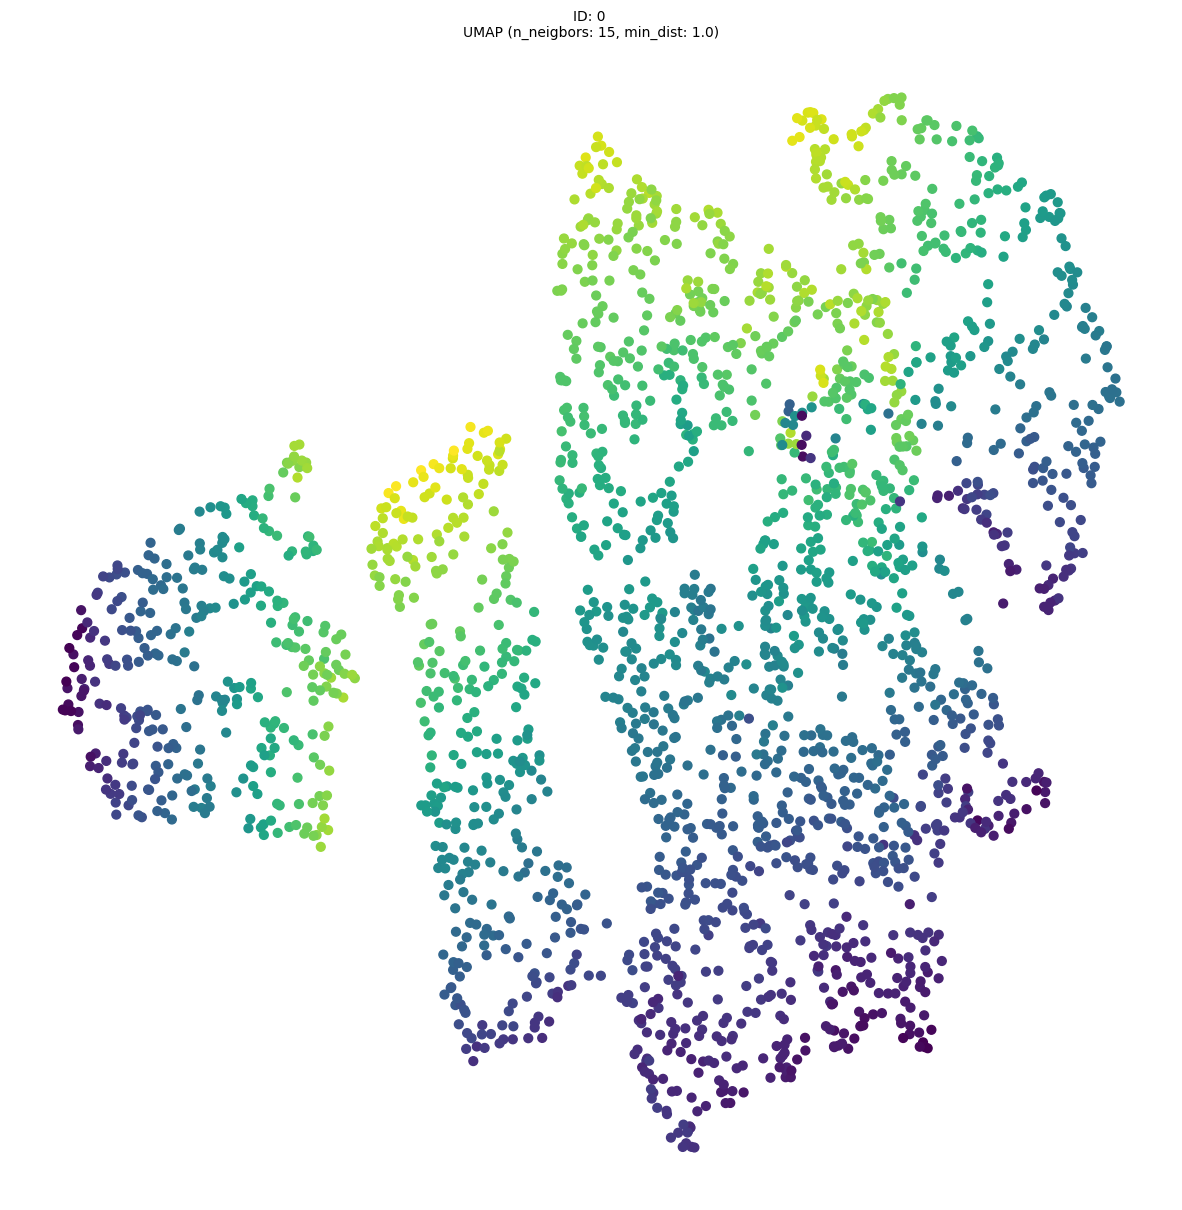

In [8]:
umap_plot = moddr.visualization.display_embeddings(
    [reference_embedding], figsize_columns=1, show_edges=False
)

## Modification via moddr-framework

The initial positioning is modified using the framework in the following way. To achieve this, the Fruchterman-Reingold (FR), Kamada-Kawai (KK) and MDS layout methods are applied in succession. Apart from the layout method, the same parameters are used for all test series (see below). Due to space constraints, outputs are omitted in the example notebooks and can be generated by local execution.

In [7]:
community_resolutions = [0.0001, 0.001, 0.005, 0.05]
n_neighbors = 15
dr_method = "UMAP"
graph_method = "DR"
boundary_neighbors = False
layout_params_fr = [10, 100, 500, 1000]
layout_params_kk_mds = [0.2, 0.4, 0.6, 0.8, 1.0]

### Modification via Fruchterman-Reingold

In [10]:
mod_embeddings_fr = moddr.processing.run_pipeline(
    data=X,
    sim_features=sim_features,
    dr_method=dr_method,
    dr_param_n_neighbors=n_neighbors,
    graph_method=graph_method,
    community_resolutions=community_resolutions,
    layout_method="FR",
    boundary_neighbors=boundary_neighbors,
    layout_params=layout_params_fr,
    compute_metrics=True,
    verbose=True,
)

------------------------------------------------------------
Start moddr pipeline with the following parameters:
Similarity Features: ['hedge-sd', 'exgreen-mean', 'region-centroid-col', 'region-centroid-row']
Dimensionality Reduction Method: UMAP with 15 neighbors
Graph Construction Method: DR
Community Detection Resolutions: [0.0001, 0.001, 0.005, 0.05]
Layout Method: FR
Boundary Neighbors: False
Layout Parameters: [10, 100, 500, 1000]
Compute Metrics: True

INFO: Inverting distances via 1 - distances, as normalization is applied.
------------------------------------------------------------
Computing communities via Leiden detection for embedding 0: `UMAP (n_neigbors: 15, min_dist: 1.0)' with resolution '0.0001'.
Computation finished after 0.13 seconds.
Found 5 communities.
------------------------------------------------------------
------------------------------------------------------------
Compute new positions for embedding: `UMAP (n_neigbors: 15, min_dist: 1.0), Leiden (resoluti

In [11]:
moddr.evaluation.create_report(mod_embeddings_fr, metadata=True, metrics=True)

,obj_id,dr_method,dr_params,k_neighbors,com_detection,com_detection_params,layout_method,layout_params,trustworthiness,continuity,rnx,sim_stress,sim_stress_com,sim_stress_com_diff,rank_score,distance_score,total_score
0,0,UMAP,"{'n_neighbors': 15, 'min_dist': 1.0, 'random_s...",15,,{},,{},0.985545,0.996594,0.709096,0.632811,0.632811,0.000000,0.897078,0.433594,0.665336
1,1,UMAP,"{'n_neighbors': 15, 'min_dist': 1.0, 'random_s...",15,Leiden,{'resolution': 0.0001},FR,"{'iterations': 10, 'boundary_neighbors': False}",0.983517,0.992906,0.638041,0.687529,0.417133,0.041742,0.871488,0.395800,0.633644
2,2,UMAP,"{'n_neighbors': 15, 'min_dist': 1.0, 'random_s...",15,Leiden,{'resolution': 0.0001},FR,"{'iterations': 100, 'boundary_neighbors': False}",0.987837,0.993120,0.691834,0.688375,0.357844,-0.017547,0.890930,0.410199,0.650565
3,3,UMAP,"{'n_neighbors': 15, 'min_dist': 1.0, 'random_s...",15,Leiden,{'resolution': 0.0001},FR,"{'iterations': 500, 'boundary_neighbors': False}",0.987781,0.992951,0.687736,0.688259,0.356074,-0.019317,0.889489,0.410700,0.650095
4,4,UMAP,"{'n_neighbors': 15, 'min_dist': 1.0, 'random_s...",15,Leiden,{'resolution': 0.0001},FR,"{'iterations': 1000, 'boundary_neighbors': False}",0.987768,0.992941,0.687010,0.688267,0.356562,-0.018830,0.889239,0.410574,0.649907
5,5,UMAP,"{'n_neighbors': 15, 'min_dist': 1.0, 'random_s...",15,Leiden,{'resolution': 0.001},FR,"{'iterations': 10, 'boundary_neighbors': False}",0.992560,0.992571,0.694013,0.636249,0.297302,0.023030,0.893048,0.426118,0.659583
6,6,UMAP,"{'n_neighbors': 15, 'min_dist': 1.0, 'random_s...",15,Leiden,{'resolution': 0.001},FR,"{'iterations': 100, 'boundary_neighbors': False}",0.993824,0.992396,0.733304,0.636720,0.260815,-0.013456,0.906508,0.435004,0.670756
7,7,UMAP,"{'n_neighbors': 15, 'min_dist': 1.0, 'random_s...",15,Leiden,{'resolution': 0.001},FR,"{'iterations': 500, 'boundary_neighbors': False}",0.993769,0.992366,0.730573,0.636774,0.262839,-0.011432,0.905569,0.434471,0.670020
8,8,UMAP,"{'n_neighbors': 15, 'min_dist': 1.0, 'random_s...",15,Leiden,{'resolution': 0.001},FR,"{'iterations': 1000, 'boundary_neighbors': False}",0.993814,0.992362,0.729904,0.636737,0.262936,-0.011335,0.905360,0.434465,0.669913
9,9,UMAP,"{'n_neighbors': 15, 'min_dist': 1.0, 'random_s...",15,Leiden,{'resolution': 0.005},FR,"{'iterations': 10, 'boundary_neighbors': False}",0.993164,0.993088,0.726359,0.636435,0.279248,-0.024311,0.904203,0.437860,0.671032


In [ ]:
metrics_report_fr = moddr.evaluation.create_report(
    mod_embeddings_fr, metadata=False, metrics=True
)
metrics_plot_fr = moddr.visualization.plot_metrics_report(metrics_report_fr)

In [ ]:
embedding_graphs_fr = moddr.visualization.display_embeddings(
    mod_embeddings_fr, figsize_columns=3, show_edges=False
)

### Modification via Kamada-Kawai

In [8]:
mod_embeddings_kk = moddr.processing.run_pipeline(
    data=X,
    sim_features=sim_features,
    dr_method=dr_method,
    dr_param_n_neighbors=n_neighbors,
    graph_method=graph_method,
    community_resolutions=community_resolutions,
    layout_method="KK",
    boundary_neighbors=boundary_neighbors,
    layout_params=layout_params_kk_mds,
    compute_metrics=True,
    verbose=True,
)

------------------------------------------------------------
Start moddr pipeline with the following parameters:
Similarity Features: ['hedge-sd', 'exgreen-mean', 'region-centroid-col', 'region-centroid-row']
Dimensionality Reduction Method: UMAP with 15 neighbors
Graph Construction Method: DR
Community Detection Resolutions: [0.0001, 0.001, 0.005, 0.05]
Layout Method: KK
Boundary Neighbors: False
Layout Parameters: [0.2, 0.4, 0.6, 0.8, 1.0]
Compute Metrics: True

------------------------------------------------------------
Computing communities via Leiden detection for embedding 0: `UMAP (n_neigbors: 15, min_dist: 1.0)' with resolution '0.0001'.
Computation finished after 0.18 seconds.
Found 5 communities.
------------------------------------------------------------
------------------------------------------------------------
Compute new positions for embedding: `UMAP (n_neigbors: 15, min_dist: 1.0), Leiden (resolution: 0.0001)'.
Start computation with Kamada Kawai-algorithm.
Computat

Detailed overview of all iterations

In [9]:
moddr.evaluation.create_report(mod_embeddings_kk, metadata=True, metrics=True)

,obj_id,dr_method,dr_params,k_neighbors,com_detection,com_detection_params,layout_method,layout_params,trustworthiness,continuity,rnx,sim_stress,sim_stress_com,sim_stress_com_diff,rank_score,distance_score,total_score
0,0,UMAP,"{'n_neighbors': 15, 'min_dist': 1.0, 'random_s...",15,,{},,{},0.985545,0.996594,0.709096,0.632811,0.632811,0.000000,0.897078,0.433594,0.665336
1,1,UMAP,"{'n_neighbors': 15, 'min_dist': 1.0, 'random_s...",15,Leiden,{'resolution': 0.0001},KK,"{'balance_factor': 0.2, 'boundary_neighbors': ...",0.986135,0.996529,0.706452,0.636488,0.361046,0.001856,0.896372,0.431292,0.663832
2,2,UMAP,"{'n_neighbors': 15, 'min_dist': 1.0, 'random_s...",15,Leiden,{'resolution': 0.0001},KK,"{'balance_factor': 0.4, 'boundary_neighbors': ...",0.986467,0.996362,0.704185,0.640490,0.364484,0.005294,0.895671,0.428431,0.662051
3,3,UMAP,"{'n_neighbors': 15, 'min_dist': 1.0, 'random_s...",15,Leiden,{'resolution': 0.0001},KK,"{'balance_factor': 0.6, 'boundary_neighbors': ...",0.989199,0.996143,0.707033,0.644822,0.369697,0.010507,0.897458,0.424962,0.661210
4,4,UMAP,"{'n_neighbors': 15, 'min_dist': 1.0, 'random_s...",15,Leiden,{'resolution': 0.0001},KK,"{'balance_factor': 0.8, 'boundary_neighbors': ...",0.989203,0.995762,0.700727,0.649505,0.376726,0.017536,0.895231,0.420863,0.658047
5,5,UMAP,"{'n_neighbors': 15, 'min_dist': 1.0, 'random_s...",15,Leiden,{'resolution': 0.0001},KK,"{'balance_factor': 1.0, 'boundary_neighbors': ...",0.988865,0.995140,0.691194,0.654542,0.385592,0.026403,0.891733,0.416129,0.653931
6,6,UMAP,"{'n_neighbors': 15, 'min_dist': 1.0, 'random_s...",15,Leiden,{'resolution': 0.001},KK,"{'balance_factor': 0.2, 'boundary_neighbors': ...",0.979988,0.996309,0.679308,0.631949,0.293783,-0.000135,0.885202,0.434059,0.659631
7,7,UMAP,"{'n_neighbors': 15, 'min_dist': 1.0, 'random_s...",15,Leiden,{'resolution': 0.001},KK,"{'balance_factor': 0.4, 'boundary_neighbors': ...",0.968778,0.995575,0.622813,0.631208,0.296441,0.002523,0.862389,0.433765,0.648077
8,8,UMAP,"{'n_neighbors': 15, 'min_dist': 1.0, 'random_s...",15,Leiden,{'resolution': 0.001},KK,"{'balance_factor': 0.6, 'boundary_neighbors': ...",0.954488,0.994493,0.559924,0.630574,0.300502,0.006584,0.836302,0.433067,0.634684
9,9,UMAP,"{'n_neighbors': 15, 'min_dist': 1.0, 'random_s...",15,Leiden,{'resolution': 0.001},KK,"{'balance_factor': 0.8, 'boundary_neighbors': ...",0.940657,0.993158,0.503487,0.630034,0.305255,0.011338,0.812434,0.432149,0.622291


In [ ]:
metrics_report_kk = moddr.evaluation.create_report(
    mod_embeddings_kk, metadata=False, metrics=True
)
metrics_plot_kk = moddr.visualization.plot_metrics_report(metrics_report_kk)

In [ ]:
embedding_graphs_kk = moddr.visualization.display_embeddings(
    mod_embeddings_kk, figsize_columns=3, show_edges=False
)

### Modification via MDS

In [22]:
mod_embeddings_mds = moddr.processing.run_pipeline(
    data=X,
    sim_features=sim_features,
    dr_method=dr_method,
    dr_param_n_neighbors=n_neighbors,
    graph_method=graph_method,
    community_resolutions=community_resolutions,
    layout_method="MDS",
    boundary_neighbors=boundary_neighbors,
    layout_params=layout_params_kk_mds,
    compute_metrics=True,
    verbose=True,
)

------------------------------------------------------------
Start moddr pipeline with the following parameters:
Similarity Features: ['hedge-sd', 'exgreen-mean', 'region-centroid-col', 'region-centroid-row']
Dimensionality Reduction Method: UMAP with 15 neighbors
Graph Construction Method: DR
Community Detection Resolutions: [0.0001, 0.001, 0.005, 0.05]
Layout Method: MDS
Boundary Neighbors: False
Layout Parameters: [0.2, 0.4, 0.6, 0.8, 1.0]
Compute Metrics: True

------------------------------------------------------------
Computing communities via Leiden detection for embedding 0: `UMAP (n_neigbors: 15, min_dist: 1.0)' with resolution '0.0001'.
Computation finished after 0.12 seconds.
Found 5 communities.
------------------------------------------------------------
------------------------------------------------------------
Compute new positions for embedding: `UMAP (n_neigbors: 15, min_dist: 1.0), Leiden (resolution: 0.0001)'.
Start computation with MDS-algorithm.
Computation of n

Detailed overview of all iterations

In [23]:
moddr.evaluation.create_report(mod_embeddings_mds, metadata=True, metrics=True)

,obj_id,dr_method,dr_params,k_neighbors,com_detection,com_detection_params,layout_method,layout_params,trustworthiness,continuity,rnx,sim_stress,sim_stress_com,sim_stress_com_diff,rank_score,distance_score,total_score
0,0,UMAP,"{'n_neighbors': 15, 'min_dist': 1.0, 'random_s...",15,,{},,{},0.985545,0.996594,0.709096,0.632811,0.632811,0.000000,0.897078,0.433594,0.665336
1,1,UMAP,"{'n_neighbors': 15, 'min_dist': 1.0, 'random_s...",15,Leiden,{'resolution': 0.0001},MDS,"{'balance_factor': 0.2, 'boundary_neighbors': ...",0.974007,0.996238,0.678262,0.629560,0.319903,-0.039286,0.882836,0.445041,0.663939
2,2,UMAP,"{'n_neighbors': 15, 'min_dist': 1.0, 'random_s...",15,Leiden,{'resolution': 0.0001},MDS,"{'balance_factor': 0.4, 'boundary_neighbors': ...",0.949318,0.994841,0.620488,0.624382,0.286364,-0.072826,0.854882,0.456016,0.655449
3,3,UMAP,"{'n_neighbors': 15, 'min_dist': 1.0, 'random_s...",15,Leiden,{'resolution': 0.0001},MDS,"{'balance_factor': 0.6, 'boundary_neighbors': ...",0.930137,0.993045,0.573147,0.617723,0.256650,-0.102539,0.832110,0.466773,0.649441
4,4,UMAP,"{'n_neighbors': 15, 'min_dist': 1.0, 'random_s...",15,Leiden,{'resolution': 0.0001},MDS,"{'balance_factor': 0.8, 'boundary_neighbors': ...",0.916153,0.991015,0.528742,0.610062,0.233051,-0.126139,0.811970,0.476503,0.644237
5,5,UMAP,"{'n_neighbors': 15, 'min_dist': 1.0, 'random_s...",15,Leiden,{'resolution': 0.0001},MDS,"{'balance_factor': 1.0, 'boundary_neighbors': ...",0.903719,0.988811,0.488492,0.601951,0.219870,-0.139319,0.793674,0.483855,0.638764
6,6,UMAP,"{'n_neighbors': 15, 'min_dist': 1.0, 'random_s...",15,Leiden,{'resolution': 0.001},MDS,"{'balance_factor': 0.2, 'boundary_neighbors': ...",0.975221,0.996202,0.676489,0.632590,0.255061,-0.046942,0.882637,0.445441,0.664039
7,7,UMAP,"{'n_neighbors': 15, 'min_dist': 1.0, 'random_s...",15,Leiden,{'resolution': 0.001},MDS,"{'balance_factor': 0.4, 'boundary_neighbors': ...",0.959514,0.994590,0.608602,0.630763,0.219671,-0.082332,0.854235,0.455202,0.654718
8,8,UMAP,"{'n_neighbors': 15, 'min_dist': 1.0, 'random_s...",15,Leiden,{'resolution': 0.001},MDS,"{'balance_factor': 0.6, 'boundary_neighbors': ...",0.939481,0.992308,0.551468,0.627331,0.193482,-0.108521,0.827752,0.463465,0.645608
9,9,UMAP,"{'n_neighbors': 15, 'min_dist': 1.0, 'random_s...",15,Leiden,{'resolution': 0.001},MDS,"{'balance_factor': 0.8, 'boundary_neighbors': ...",0.920106,0.989679,0.498431,0.622650,0.177947,-0.124056,0.802739,0.469689,0.636214


In [ ]:
metrics_report_mds = moddr.evaluation.create_report(
    mod_embeddings_mds, metadata=False, metrics=True
)
metrics_plot_mds = moddr.visualization.plot_metrics_report(metrics_report_mds)

In [ ]:
embedding_graphs_mds = moddr.visualization.display_embeddings(
    mod_embeddings_mds, figsize_columns=3, show_edges=False
)